In [11]:
# header files
import torch
import torch.nn as nn
import torchvision
from torch.optim import lr_scheduler
import torch.utils.model_zoo as model_zoo
import numpy as np
import skimage
from skimage import io, transform
import glob
import csv
from PIL import Image
import time
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#from torch.utils.tensorboard import SummaryWriter

In [2]:
# ensure same result is produced
torch.backends.cudnn.benchmark = True
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

In [3]:
# dataset paths
train_path = glob.glob("qcdata_5channel/final_train*")
val_path = glob.glob("qcdata_5channel/final_val*")

In [4]:
# hyperparameters
batch_size = 18
lr = 0.1
num_epochs = 31
output_classes = 3
image_size = 512

In [5]:
# create PyTorch dataset class
class ImageQC_Dataset(torch.utils.data.Dataset):
    """
        ImageQC Dataset.
    """
    
    # init method
    def __init__(self, files, img_size=1024, is_train=True):
        """
        Args:
            root (string): path of the directory which contains the required images and masks
            transform (torchvision.transforms): transforms applied on the given image
            img_size: random crop to be taken during training
        """
        self.files = files
        self.img_size = img_size
        
        # get the file paths and their corresponding labels(0: good, 1: blurry, 2: empty, 3: debris)
        self.labels_0 = []
        self.image_path_dna_0 = []
        self.image_path_rna_0 = []
        self.image_path_er_0 = []
        self.image_path_mito_0 = []
        self.image_path_agp_0 = []
        
        self.labels_2 = []
        self.image_path_dna_2 = []
        self.image_path_rna_2 = []
        self.image_path_er_2 = []
        self.image_path_mito_2 = []
        self.image_path_agp_2 = []
        
        self.labels_3 = []
        self.image_path_dna_3 = []
        self.image_path_rna_3 = []
        self.image_path_er_3 = []
        self.image_path_mito_3 = []
        self.image_path_agp_3 = []
        
        self.labels = []
        self.image_path_dna = []
        self.image_path_rna = []
        self.image_path_er = []
        self.image_path_mito = []
        self.image_path_agp = []
        for file in files:
            flag = -1
    
            with open(file, newline='') as csvfile:
                spamreader = csv.reader(csvfile)
                for row in spamreader:
                    if flag == -1:
                        flag = 1
                    else:
                        array = row
                        fixed_path = "/dgx1nas1/cellpainting-datasets/2019_07_11_JUMP_CP_pilots"
                        dna_path = array[0].split("/")
                        rna_path = array[1].split("/")
                        er_path = array[2].split("/")
                        mito_path = array[3].split("/")
                        agp_path = array[4].split("/")
                        
                        if dna_path[1] == "dgx1nas1":
                            if int(array[5]) == 0:
                                self.image_path_dna_0.append(str(array[0]))
                                self.image_path_rna_0.append(str(array[1]))
                                self.image_path_er_0.append(str(array[2]))
                                self.image_path_mito_0.append(str(array[3]))
                                self.image_path_agp_0.append(str(array[4]))
                                self.labels_0.append(str(array[5]))
                            elif int(array[5]) == 2:
                                self.image_path_dna_2.append(str(array[0]))
                                self.image_path_rna_2.append(str(array[1]))
                                self.image_path_er_2.append(str(array[2]))
                                self.image_path_mito_2.append(str(array[3]))
                                self.image_path_agp_2.append(str(array[4]))
                                self.labels_2.append(str(array[5]))
                            elif int(array[5]) == 3:
                                self.image_path_dna_3.append(str(array[0]))
                                self.image_path_rna_3.append(str(array[1]))
                                self.image_path_er_3.append(str(array[2]))
                                self.image_path_mito_3.append(str(array[3]))
                                self.image_path_agp_3.append(str(array[4]))
                                self.labels_3.append(str(array[5]))
                        else:
                            new_dna_path = fixed_path
                            new_rna_path = fixed_path
                            new_er_path = fixed_path
                            new_mito_path = fixed_path
                            new_agp_path = fixed_path
                            for index in range(3, len(dna_path)):
                                new_dna_path = new_dna_path + "/" + dna_path[index]
                                new_rna_path = new_rna_path + "/" + rna_path[index]
                                new_er_path = new_er_path + "/" + er_path[index]
                                new_mito_path = new_mito_path + "/" + mito_path[index]
                                new_agp_path = new_agp_path + "/" + agp_path[index]
                                
                            if int(array[5]) == 0:
                                self.image_path_dna_0.append(str(new_dna_path))
                                self.image_path_rna_0.append(str(new_rna_path))
                                self.image_path_er_0.append(str(new_er_path))
                                self.image_path_mito_0.append(str(new_mito_path))
                                self.image_path_agp_0.append(str(new_agp_path))
                                self.labels_0.append(str(array[5]))
                            elif int(array[5]) == 2:
                                self.image_path_dna_2.append(str(new_dna_path))
                                self.image_path_rna_2.append(str(new_rna_path))
                                self.image_path_er_2.append(str(new_er_path))
                                self.image_path_mito_2.append(str(new_mito_path))
                                self.image_path_agp_2.append(str(new_agp_path))
                                self.labels_2.append(str(array[5]))
                            elif int(array[5]) == 3:
                                self.image_path_dna_3.append(str(new_dna_path))
                                self.image_path_rna_3.append(str(new_rna_path))
                                self.image_path_er_3.append(str(new_er_path))
                                self.image_path_mito_3.append(str(new_mito_path))
                                self.image_path_agp_3.append(str(new_agp_path))
                                self.labels_3.append(str(array[5]))
                                
        # get good, empty and debris images
        if is_train == True:
            n = 10000
            index = np.random.choice(len(self.labels_0), n, replace=False)
            for index1 in range(0, len(index)):
                self.image_path_dna.append(self.image_path_dna_0[index[index1]])
                self.image_path_rna.append(self.image_path_rna_0[index[index1]])
                self.image_path_er.append(self.image_path_er_0[index[index1]])
                self.image_path_mito.append(self.image_path_mito_0[index[index1]])
                self.image_path_agp.append(self.image_path_agp_0[index[index1]])
                self.labels.append("0")
        else:
            n = len(self.labels_0)
            index = np.random.choice(len(self.labels_0), n, replace=False)
            for index1 in range(0, len(index)):
                self.image_path_dna.append(self.image_path_dna_0[index[index1]])
                self.image_path_rna.append(self.image_path_rna_0[index[index1]])
                self.image_path_er.append(self.image_path_er_0[index[index1]])
                self.image_path_mito.append(self.image_path_mito_0[index[index1]])
                self.image_path_agp.append(self.image_path_agp_0[index[index1]])
                self.labels.append("0")
        
        for index1 in range(0, len(self.labels_2)):
            self.image_path_dna.append(self.image_path_dna_2[index1])
            self.image_path_rna.append(self.image_path_rna_2[index1])
            self.image_path_er.append(self.image_path_er_2[index1])
            self.image_path_mito.append(self.image_path_mito_2[index1])
            self.image_path_agp.append(self.image_path_agp_2[index1])
            self.labels.append("2")
            
        for index1 in range(0, len(self.labels_3)):
            self.image_path_dna.append(self.image_path_dna_3[index1])
            self.image_path_rna.append(self.image_path_rna_3[index1])
            self.image_path_er.append(self.image_path_er_3[index1])
            self.image_path_mito.append(self.image_path_mito_3[index1])
            self.image_path_agp.append(self.image_path_agp_3[index1])
            self.labels.append("3")
            
        #print(len(self.labels_0))
        #print(len(self.labels_2))
        #print(len(self.labels_3))
                                
                
    # getitem method
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        """
        # read each channel
        image_dna = skimage.io.imread(self.image_path_dna[index], plugin='pil')
        image_rna = skimage.io.imread(self.image_path_rna[index], plugin='pil')
        image_er = skimage.io.imread(self.image_path_er[index], plugin='pil')
        image_mito = skimage.io.imread(self.image_path_mito[index], plugin='pil')
        image_agp = skimage.io.imread(self.image_path_agp[index], plugin='pil')
        
        # resize each channel
        image_dna = skimage.transform.resize(image_dna, [self.img_size, self.img_size], mode='constant', preserve_range=True, order=0)
        image_rna = skimage.transform.resize(image_rna, [self.img_size, self.img_size], mode='constant', preserve_range=True, order=0)
        image_er = skimage.transform.resize(image_er, [self.img_size, self.img_size], mode='constant', preserve_range=True, order=0)
        image_mito = skimage.transform.resize(image_mito, [self.img_size, self.img_size], mode='constant', preserve_range=True, order=0)
        image_agp = skimage.transform.resize(image_agp, [self.img_size, self.img_size], mode='constant', preserve_range=True, order=0)
        
        # convert each channel to type uint8
        image_dna = image_dna / float(image_dna.max())
        image_dna = 255. * image_dna
        image_rna = image_rna / float(image_rna.max())
        image_rna = 255. * image_rna
        image_er = image_er / float(image_er.max())
        image_er = 255. * image_er
        image_mito = image_mito / float(image_mito.max())
        image_mito = 255. * image_mito
        image_agp = image_agp / float(image_agp.max())
        image_agp = 255. * image_agp
        
        # convert them to PyTorch tensor
        image_dna = torch.from_numpy(np.array(image_dna).astype('uint8'))
        image_rna = torch.from_numpy(np.array(image_rna).astype('uint8'))
        image_er = torch.from_numpy(np.array(image_er).astype('uint8'))
        image_mito = torch.from_numpy(np.array(image_mito).astype('uint8'))
        image_agp = torch.from_numpy(np.array(image_agp).astype('uint8'))
        
        # normalize the images and merge
        image_dna = image_dna / 255.
        image_rna = image_rna / 255.
        image_er = image_er / 255.
        image_mito = image_mito / 255.
        image_agp = image_agp / 255.
        image = torch.stack((image_dna, image_er, image_rna, image_agp, image_mito))
        
        # label
        label = int(self.labels[index])
        if(label == 2):
            label = 1
        if(label == 3):
            label = 2
        
        # return the image and the corresponding label
        return image, label

    # len method
    def __len__(self):
        """
        Returns:
            int: number of images in the directory
        """
        return len(self.labels)

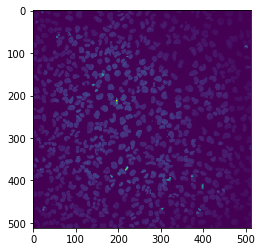

In [6]:
# view images
dataset = ImageQC_Dataset(train_path, img_size=image_size)
plt.imshow(dataset.__getitem__(5)[0].numpy()[0])

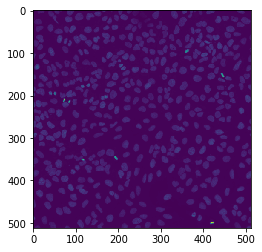

In [7]:
# view images
dataset = ImageQC_Dataset(train_path, img_size=image_size)
plt.imshow(dataset.__getitem__(25)[0].numpy()[0])

In [8]:
# handling class imbalance during training 
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None, weights=None):
                
        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        label_to_count[0] = 10000
        label_to_count[1] = 1560
        label_to_count[2] = 475
                
        # weight for each sample
        if weights == None:
            weights = [1.0 / label_to_count[self._get_label(dataset, idx)] for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        if self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels[idx].item()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return dataset.imgs[idx][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[idx][1]
        else:
            return dataset.__getitem__(idx)[1]
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [9]:
# create PyTorch dataset class and create train data and val data
train_data = ImageQC_Dataset(train_path, img_size=image_size)
val_data = ImageQC_Dataset(val_path, img_size=image_size, is_train=False)
print(len(train_data))
print(len(val_data))

12035
600


In [10]:
# load the data
weights = []
for index in range(0, 10000):
    weights.append(1. / 10000)
for index in range(0, 1560):
    weights.append(1. / 1560)
for index in range(0, 475):
    weights.append(1. / 475)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=24, sampler=ImbalancedDatasetSampler(train_data, weights=weights))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=24)

In [14]:
# required functions
__all__ = ['resnet18', 'resnet50']

model_files = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1, arma=False):
    """
        in_planes: number of input channels
        out_planes: number of output channels
        stride: the stride value
        groups: the number of groups
        dilation: the gap between kernel cells
        arma: True, then arma layer applied, otherwise conv layer
    """
    if arma:
      return ARMA2d(in_planes, out_planes, w_kernel_size=3, w_padding=dilation, w_stride=stride, w_groups=groups, w_dilation=dilation, bias=False)
    else:
      return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1, arma=False):
    """
        in_planes: number of input channels
        out_planes: number of output channels
        stride: the stride value
        arma: True, then arma layer applied, otherwise conv layer
    """
    if arma:
      return ARMA2d(in_planes, out_planes, w_kernel_size=1, w_stride=stride, w_padding=0, bias=False)
    else:
      return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, dilation=1, norm_layer=None, arma=False):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation>1 not supported in BasicBlock")

        self.conv1 = conv3x3(inplanes, planes, stride, arma=arma)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, arma=arma)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, dilation=1, norm_layer=None, arma=False):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes*(base_width/64.))*groups
        
        self.conv1 = conv1x1(inplanes, width, arma=arma)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation, arma=arma)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes*4, arma=arma)
        self.bn3 = norm_layer(planes*4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5, zero_init_residual=False, groups=1, width_per_group=64, replace_stride_with_dilation=None, norm_layer=None, sa=False, ca=False, arma=False):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        self.sa = sa
        self.ca = ca
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        if(arma):
            self.conv1 = ARMA2d(3, self.inplanes, w_kernel_size=7, w_stride=2, w_padding=3, bias=False)
        else:
            self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], arma=arma)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0], arma=arma)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1], arma=arma)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2], arma=arma)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fraw = torch.nn.Sequential(
            torch.nn.Conv2d(2048, 512, kernel_size=1, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True)
        )
        
        self.spatial_attention = torch.nn.Sequential(
            torch.nn.Conv2d(512, 1, kernel_size=1, bias=False),
            torch.nn.BatchNorm2d(1),
            torch.nn.ReLU(inplace=True)
        )

        self.ca_squeeze = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.ca_excitation = torch.nn.Sequential(
            torch.nn.Linear(512, 128, bias=False),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(128, 512, bias=False),
            torch.nn.Sigmoid()
        )

        if(sa): 
            self.fc_new = torch.nn.Sequential(
                torch.nn.Linear(512, 512),
                torch.nn.ReLU(inplace=True),
                torch.nn.Dropout(0.5),
                torch.nn.Linear(512, 512),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(512, num_classes)
            )
        else:
            self.fc_new = nn.Linear(512*block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False, arma=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes*block.expansion, stride, arma=arma),
                norm_layer(planes*block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer, arma=arma))
        self.inplanes = planes*block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups, base_width=self.base_width, dilation=self.dilation, norm_layer=norm_layer, arma=arma))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # apply channel attention and spatial attention
        if(self.ca and self.sa):
            x = self.fraw(x)

            # channel attention
            scale = self.ca_squeeze(x).view(int(x.shape[0]), int(x.shape[1]))
            scale = self.ca_excitation(scale).view(int(x.shape[0]), int(x.shape[1]), 1, 1)
            fca = x * scale.expand_as(x)
            
            # spatial attention
            scale = self.spatial_attention(fca)
            x = fca * scale

        # apply spatial attention
        if(self.sa):
            x = self.fraw(x)

            # spatial attention
            scale = self.spatial_attention(x)
            x = x * scale

        # avg pool followed by fc layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc_new(x)
        return x


# loads resnet model
def _resnet(arch, block, layers, sa=False, ca=False, **kwargs):
    # load resnet
    model = ResNet(block, layers, sa=sa, ca=ca, **kwargs)
    model.load_state_dict(model_zoo.load_url(model_files[arch]), strict=False)
    return model


def resnet50(sa=False, ca=False, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        sa (boolean): spatial attention
        ca (boolean): channel attention
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], sa=sa, ca=ca, **kwargs)

def _load_resnet(arch_type, num_classes, sa=True, ca=True):
    backbone = resnet50(num_classes=num_classes, sa=sa, ca=ca)
    return backbone

def sgd_resnet50(num_classes=3, sa=True, ca=True):
    """Constructs a ResNet-50 model.
    Args:
        num_classes (int): number of classes.
        sa (boolean): spatial attention
        ca (boolean): channel attention
    """
    return _load_resnet('resnet50', num_classes=num_classes, sa=sa, ca=ca)

In [15]:
# load model
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = sgd_resnet50(num_classes=output_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [17]:
# Cross-Entropy loss with Label Smoothing
class CrossEntropyLabelSmoothingLoss(nn.Module):
    
    def __init__(self, smoothing=0.0):
        super(CrossEntropyLabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
    
    def forward(self, pred, target):
        log_prob = torch.nn.functional.log_softmax(pred, dim=-1)
        weight = input.new_ones(pred.size()) * (self.smoothing/(pred.size(-1)-1.))
        weight.scatter_(-1, target.unsqueeze(-1), (1.-self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

In [18]:
# define loss (smoothing=0 is equivalent to standard Cross-Entropy loss)
criterion = CrossEntropyLabelSmoothingLoss(0.0)

In [19]:
# metrics class
class _StreamMetrics(object):
    def __init__(self):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def update(self, gt, pred):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def get_results(self):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def to_str(self, metrics):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def reset(self):
        """ Overridden by subclasses """
        raise NotImplementedError()      

class StreamMetrics(_StreamMetrics):
    """
    Stream Metrics for Semantic Segmentation Task
    """
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist( lt.flatten(), lp.flatten() )
    
    @staticmethod
    def to_str(results):
        string = "\n"
        for k, v in results.items():
            if k!="Class IoU":
                string += "%s: %f\n"%(k, v)
        
        #string+='Class IoU:\n'
        #for k, v in results['Class IoU'].items():
        #    string += "\tclass %d: %f\n"%(k, v)
        return string

    def _fast_hist(self, label_true, label_pred):
        mask = (label_true >= 0) & (label_true < self.n_classes)
        hist = np.bincount(
            self.n_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.n_classes ** 2,
        ).reshape(self.n_classes, self.n_classes)
        return hist

    def get_results(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))

        return {
                "Overall Acc": acc,
                "Mean Acc": acc_cls,
                "FreqW Acc": fwavacc,
                "Mean IoU": mean_iu,
                "Class IoU": cls_iu,
                "Confusion Matrix": hist
            }
        
    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

class AverageMeter(object):
    """Computes average values"""
    def __init__(self):
        self.book = dict()

    def reset_all(self):
        self.book.clear()
    
    def reset(self, id):
        item = self.book.get(id, None)
        if item is not None:
            item[0] = 0
            item[1] = 0

    def update(self, id, val):
        record = self.book.get(id, None)
        if record is None:
            self.book[id] = [val, 1]
        else:
            record[0]+=val
            record[1]+=1

    def get_results(self, id):
        record = self.book.get(id, None)
        assert record is not None
        return record[0] / record[1]

In [ ]:
metrics = StreamMetrics(output_classes)
best_metric = -1
best_metric_epoch = -1
train_loss = []
val_loss = []
train_acc = []
val_acc = []
confusion_matrix = None
#writer = SummaryWriter("./logs/")
#writer.flush()

# train and validate
for epoch in range(0, num_epochs):
    print("Epoch: " + str(epoch))
    print()
    
    # train
    metrics.reset()
    model.train()
    training_loss = 0.0
    total = 0
    correct = 0
    for i, (input, target) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        training_loss = training_loss + loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
    training_loss = training_loss/float(len(train_loader))
    training_accuracy = str(100.0*(float(correct)/float(total)))
    train_acc.append(training_accuracy)
    train_loss.append(training_loss)
    
    #writer.add_scalar("Loss/train", float(training_loss), epoch)
    #writer.add_scalar("Accuracy/train", float(training_accuracy), epoch)
    
    # validate
    if epoch%5 == 0:
        metrics.reset()
        model.eval()
        valid_loss = 0.0
        total = 0
        correct = 0
        for i, (input, target) in enumerate(val_loader):
            with torch.no_grad():
                input = input.to(device)
                target = target.to(device)

                output = model(input)
                loss = criterion(output, target)
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
                
                # get confusion matrix
                targets = target.cpu().numpy()
                predicted = predicted.cpu().numpy()
                metrics.update(targets, predicted)
            
            valid_loss = valid_loss + loss.item()
        valid_loss = valid_loss/float(len(val_loader))
        valid_accuracy = str(100.0*(float(correct)/float(total)))
        results = metrics.get_results()
        confusion_matrix = results["Confusion Matrix"]
        val_loss.append(valid_loss)
        val_acc.append(valid_accuracy)
        #writer.add_scalar("Loss/val", float(valid_loss), epoch)
        #writer.add_scalar("Accuracy/val", float(valid_accuracy), epoch)

        # store best model
        if(float(valid_accuracy)>best_metric):
            best_metric = float(valid_accuracy)
            best_metric_epoch = epoch
            torch.save(model.state_dict(), "/home/jupyter-arpit@broadinstitu-ef612/qc_bestmodel_sgd_5channel_debris_empty_lr4_size1.pth")
    
        print()
        print("Epoch" + str(epoch) + ":")
        print("Training Accuracy: " + str(training_accuracy) + "    Validation Accuracy: " + str(valid_accuracy))
        print("Training Loss: " + str(training_loss) + "    Validation Loss: " + str(valid_loss))
        print("Best metric: " + str(best_metric))
        print(confusion_matrix)
        print()
    
    # lr scheduler
    lr_scheduler.step()
    
    
# close tensorboard writer
#writer.flush()
#writer.close()